<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/code/SV/5s/SV_unet_projection_guanape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test Guanape

In [2]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
%cd drive/My\ Drive/

/content/drive/My Drive


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils.trip import *

In [7]:
data_test = pd.read_csv('./data/SV_test_guanape.csv')

resolution = 5
data_test_new = change_resolution(data_test, resolution)
data_test_new = standardize_data(data_test_new)

data_test_new.head()

,trip,datetime,lon,lat,gaps,dive,step_speed,step_direction,lon_std,lat_std,step_speed_std,step_direction_cos,step_direction_sin
2,G1107_12_SV_T1,2007-11-19 13:42:28,-78.958106,-8.567359,0.0,0,8.306816,14.473134,1.917377,2.293521,0.412817,0.968265,0.249926
3,G1107_12_SV_T1,2007-11-19 13:42:33,-78.958196,-8.567769,0.0,0,9.340164,10.728200,1.916609,2.289293,0.464307,0.982521,0.186150
4,G1107_12_SV_T1,2007-11-19 13:42:38,-78.958359,-8.568248,0.0,0,11.251253,6.351008,1.915217,2.284353,0.559533,0.993863,0.110619
5,G1107_12_SV_T1,2007-11-19 13:42:43,-78.958489,-8.568707,0.0,0,10.611651,-2.952198,1.914107,2.279619,0.527663,0.998673,-0.051503
6,G1107_12_SV_T1,2007-11-19 13:42:48,-78.958627,-8.569070,0.0,0,8.633423,4.956724,1.912928,2.275875,0.429091,0.996260,0.086403


## Load model

In [12]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.threshold = nn.Sequential(
#             nn.BatchNorm2d(1),
            nn.Conv2d(1, 8, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = True),
            nn.ReLU()
        )

        self.cnn_input_1 = nn.Sequential(
            nn.BatchNorm1d(8+3),
            nn.Conv1d(8+3, 8, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.pooling_1 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 5, stride = 2, padding = 2, dilation = 1)
        )

        self.cnn_input_2 = nn.Sequential(
            nn.BatchNorm1d(8),
            nn.Conv1d(8, 16, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.pooling_2 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 5, stride = 2, padding = 2, dilation = 1)
        )

        self.cnn_input_3 = nn.Sequential(
            nn.BatchNorm1d(16),
            nn.Conv1d(16, 32,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(32, 32,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.upconv_2 = nn.Sequential(
             nn.ConvTranspose1d(32, 16, kernel_size = 6, stride = 2, padding = 2, dilation = 1)
         )

        self.cnn_output_2 = nn.Sequential(
            nn.BatchNorm1d(16*2),
            nn.Conv1d(16*2, 16,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 16,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.upconv_1 = nn.Sequential(
             nn.ConvTranspose1d(16, 8, kernel_size = 6, stride = 2, padding = 2, dilation = 1)
         )
        
        self.cnn_output_1 = nn.Sequential(
            nn.BatchNorm1d(8*2),
            nn.Conv1d(8*2, 8,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 4, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(4, 2, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(2, 1,  kernel_size = 5, stride = 1, padding = 2, dilation = 1)
        )

    def forward(self, x, y):
        out = self.threshold(y)
        out = torch.sum(out, 2)

        out = torch.cat((out, x.squeeze(1)), 1)

        out_1 = self.cnn_input_1(out)
        out = self.pooling_1(out_1)
        out_2 = self.cnn_input_2(out)
        out = self.pooling_2(out_2)
        out = self.cnn_input_3(out)

        out = self.upconv_2(out)
        out = torch.cat((out, out_2), 1)
        out = self.cnn_output_2(out)

        out = self.upconv_1(out)
        out = torch.cat((out, out_1), 1)
        out = self.cnn_output_1(out)


        return out

def get_score(out, y):
    out, y = out.cpu(), y.cpu()
    out = 1*(out>0)
    true_positive = np.mean(out[y == True].numpy()) 
    true_negative = 1-np.mean(out[y == False].numpy())
    
    return (round(true_positive*100) , round(true_negative*100))



In [16]:
model = torch.load('SV_unet_matrixlonlatcov_5s.pt')
window = 20
variable = ('lon_std', 'lat_std', 'gaps')

In [18]:
dive_estim = []

for i in data_test_new.trip.unique():
    # create dataset for a trajectory
    t = data_test_new[data_test_new.trip == i].copy()    
    test_set = TrajDataSet(t, window, variable, transform = ToTensor())
    
    # Test the model
    estim = np.zeros(len(t))
    nb = np.zeros(len(t))
    
    list_out = []
    model.eval()
    k = 0
    with torch.no_grad():
        for (x, y, z) in test_set:

            # Run the forward pass
            out = model(x, y.unsqueeze(1))
            
            estim[k:k + round(window)] += out.cpu().squeeze().numpy()
            nb[k:k + round(window)] += 1
            k+=1
    # # add to list by trajectory
    dive_estim.append(estim/nb)
    print(i)

data_test_new['prediction'] = 1/(1+np.exp(-np.hstack(dive_estim)))

G1107_12_SV_T1
G1107_15_SV_T1
G1107_17_SV_T1
G1107_18_SV_T1
G1107_18_SV_T2
G1107_20_SV_T1
G1107_21_SV_T1
G1107_22_SV_T1
G1107_24_SV_T1
G1107_25_SV_T1
G1107_26_SV_T1
G1107_27_SV_T1
G1107_27_SV_T2
G1107_34_SV_T1
G1107_34_SV_T2
G1107_34_SV_T3
G1107_36_SV_T1
G1107_39_SV_T1
G1107_42_SV_T2
G1107_46_SV_T1
G1107_49_SV_T2
G1107_53_SV_T1
G1107_7_SV_T1
G1107_7_SV_T2
G1107_9_SV_T1


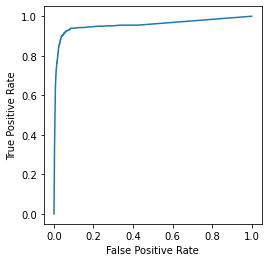

In [19]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# globally
TP = []
FP = []

for tt in np.arange(0,1,0.001):
    all_estim = 1* (data_test_new.prediction > tt)
    true_positive = np.mean(all_estim[data_test_new.dive == 1])
    true_negative = 1-np.mean(all_estim[data_test_new.dive == 0])
    TP.append(true_positive)
    FP.append(1-true_negative)

plt.plot(np.array(FP), np.array(TP))

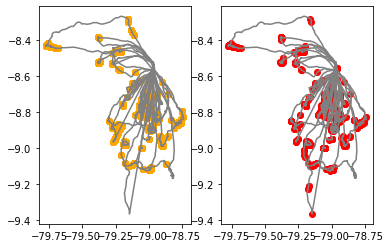

In [20]:
plt.subplot(1,2,1)
for i in data_test_new.trip.unique():
    t = data_test_new[data_test_new.trip == i].copy()
    plt.plot(np.array(t.lon), np.array(t.lat), color = 'grey')
    plt.scatter(data_test_new.lon[data_test_new.dive == 1], data_test_new.lat[data_test_new.dive == 1], color = 'orange')

plt.subplot(1,2,2)
for i in data_test_new.trip.unique():
    t = data_test_new[data_test_new.trip == i].copy()
    plt.plot(np.array(t.lon), np.array(t.lat), color = 'grey')
plt.scatter(data_test_new.lon[data_test_new.prediction > 0.9], data_test_new.lat[data_test_new.prediction > 0.9], color = 'red')

# Export Probabilities

In [21]:
data_test_new.to_csv('SV_unet_GNP.csv', index = False)